## Import Libraries

In [278]:
import numpy as np
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

## Load the Dataset

In [279]:
# Load the data set
data = pd.read_csv("Trading-features.csv")

In [280]:
# data

In [281]:
# Give all the data information
# data.describe(include = 'all')

In [282]:
# check the length and shape of the data
print(f"There are {len(data)} rows in the dataset.")
print(f"Shape of Data is {data.shape}",) # >>> (rows , columns)

There are 10000 rows in the dataset.
Shape of Data is (10000, 164)


## Change the Date Column into Date Time Object & Extract Only Time

In [283]:
# Convert the date into DateTime Instance
data['created_at'] = pd.to_datetime(data['created_at'])
# Extract the date
data['created_at'] = data['created_at'].dt.strftime('%H:%M:%S')
# Convert 'time' to numeric representation (total seconds since midnight)
data['created_at'] = pd.to_datetime(data['created_at'], format='%H:%M:%S').dt.hour * 3600 + \
                     pd.to_datetime(data['created_at'], format='%H:%M:%S').dt.minute * 60 + \
                     pd.to_datetime(data['created_at'], format='%H:%M:%S').dt.second

## Swap the first ans second column <<Target At 0th Index>>

In [284]:
# Swap the columns  id>><<last_price
data = data[[data.columns[1], data.columns[0]] + list(data.columns[2:])]

## Count the Null Values in Each Column and Remove Null values

In [285]:
print('Columns with null values and their counts:')
null_columns = data.columns[data.isnull().any()]
for column in null_columns:
    null_count = data[column].isnull().sum()
    null_percentage = (null_count / len(data)) * 100
    print(f'{column}: {null_count} null values ({null_percentage:.2f}%)')


Columns with null values and their counts:
f24: 21 null values (0.21%)
f47: 21 null values (0.21%)
f48: 8 null values (0.08%)
f49: 8 null values (0.08%)
f50: 21 null values (0.21%)
f61: 21 null values (0.21%)
f62: 8 null values (0.08%)
f63: 21 null values (0.21%)
f64: 8 null values (0.08%)
f65: 21 null values (0.21%)
f66: 8 null values (0.08%)
f67: 21 null values (0.21%)
f68: 8 null values (0.08%)
f69: 21 null values (0.21%)
f70: 8 null values (0.08%)
f71: 21 null values (0.21%)
f72: 8 null values (0.08%)
f73: 21 null values (0.21%)
f74: 8 null values (0.08%)
f75: 21 null values (0.21%)
f76: 8 null values (0.08%)
f101: 8 null values (0.08%)
f106: 8 null values (0.08%)
f108: 8 null values (0.08%)
f110: 8 null values (0.08%)
f121: 8 null values (0.08%)


In [286]:
# Remove columns containing null values and ensure that the removal does not significantly reduce the amount of data.
data.dropna(inplace=True)
data.shape

(9979, 164)

In [287]:
# Drop the row with all zeros values
data = data.loc[(data != 0).any(axis=1)]
data.shape

(9979, 164)

In [288]:
# For the next use
same_data  = data

# Select the Features On the Basis of Correlation Score

### Find the Correlation

In [289]:
# Finding the correlation
correlation_matrix = data.corr()

### Correlation of Each Column with Target

In [290]:
# Finding the correlation of each column with price
correlations_with_price = correlation_matrix.iloc[0,1:]
correlations_with_price

id            0.869998
created_at    0.869711
f1            0.543025
f2           -0.869708
f3           -0.747770
                ...   
f157          0.983121
f158          0.983121
f159         -0.300971
f160         -0.300971
f161          0.983121
Name: last_price, Length: 163, dtype: float64

### Sort the Correlation of Each Column/Feature with Target

In [291]:
# Sort features by absolute correlation values
sorted_abs_correlations = correlations_with_price.abs().sort_values(ascending=False)
sorted_abs_correlations

f161    0.983121
f150    0.983121
f158    0.983121
f157    0.983121
f154    0.983121
          ...   
f67          NaN
f69          NaN
f71          NaN
f73          NaN
f75          NaN
Name: last_price, Length: 163, dtype: float64

### Visualize the Correlation of Each Column/Feature with Target

In [292]:
# # Filter columns with NaN correlations
# nan_columns = correlations_with_price[correlations_with_price.isna()].index
#
# # Create a bar plot for both NAN and NON NAN correlation values
# plt.figure(figsize=(12, 6))
#
#
# # Bar plot for Non-NaN correlation values
# non_nan_columns_barplot = sns.barplot(x=correlations_with_price.index, y=correlations_with_price.values, color='grey', alpha=0.7, label='Columns with NoN-NaN Correlation')
#
#
# nan_columns_scatter = sns.scatterplot(x=nan_columns, y=[0] * len(nan_columns), color='red', marker='.', s=100, label='Columns with NaN Correlation')
#
#
# plt.xticks(rotation=45, ha='right')
# plt.title('Correlation of Columns with Price (Including NaN Values)')
# plt.xlabel('Columns')
# plt.ylabel('Price Correlation')
# plt.legend()
# plt.show()


### Columns/Features having NAN Correlation

In [293]:
# # Filter columns with NaN correlations
# nan_columns = correlations_with_price[correlations_with_price.isna()].index
#
# # Create a bar plot for NaN correlation values only
# plt.figure(figsize=(12, 6))
#
# # # Bar plot for NaN correlation values
# # nan_columns_barplot = sns.barplot(x=nan_columns, y=[0] * len(nan_columns), color='red', label='Columns with NaN Correlation')
#
# nan_columns_scatter = sns.scatterplot(x=nan_columns, y=[0] * len(nan_columns), color='red', marker='.', s=100, label='Columns with NaN Correlation')
#
#
# plt.xticks(rotation=45, ha='right')
# plt.title('Columns with NaN Correlation to Price')
# plt.xlabel('Columns')
# plt.ylabel('Price Correlation')
# plt.legend()
# plt.show()


### Columns/Feature  with all Values == Zero (NAN Correlation)

In [294]:
# Columns with all values zero (NaN correlation with price)
zero_columns = [column for column in data.columns if (data[column] == 0).all()]
print("Columns with all zero values:", zero_columns)
# data = data.drop(zero_columns, axis=1)
# data.shape

Columns with all zero values: ['f24', 'f47', 'f50', 'f61', 'f63', 'f65', 'f67', 'f69', 'f71', 'f73', 'f75']


In [295]:
# # Plot the (scatter) of all columns with zeros values
# fig, ax = plt.subplots()
#
# # Iterating through zero_columns
# for column in zero_columns:
#     ax.scatter(data[column], data['last_price'], label=column)
#
# ax.set_title('Scatter Plots of Columns with Zero values vs last_price')
# ax.set_xlabel('Zero Columns')
# ax.set_ylabel('last_price')
# ax.legend()
# plt.show()

In [296]:
# # target variable
# y = data['last_price']
#
# # Determine the number of rows and columns for subplots
# num_features = len(zero_columns)
# num_rows = int(np.ceil(num_features / 3))
# num_cols = min(num_features, 3)
#
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
# axes = axes.flatten()
#
# # Loop through each column and plot the scatter plot in the corresponding subplot
# for feature_index, ax in enumerate(axes):
#     if feature_index < num_features:
#         chosen_feature = data[zero_columns[feature_index]]
#
#         ax.scatter(chosen_feature, y, color='black')
#         ax.set_xlabel(f'{zero_columns[feature_index]}')
#         ax.set_ylabel('last_price')
#         ax.set_title(f'Scatter Plot for {zero_columns[feature_index]} against last_price')
#
# # Adjust layout for better spacing
# plt.tight_layout()
# plt.show()

### Filter the Columns/Feature having Corelation > 0.5 OR < 0.5

In [297]:
# Filter features  correlation greater than 0.4 and < -0.4
selected_features = correlations_with_price[(correlations_with_price > 0.5) | (correlations_with_price < -0.5)]
print(f"Count of Selected Features : {len(selected_features)}")
# print("Selected Features: ",len(selected_features))
# selected_features

Count of Selected Features : 16


In [298]:
# # Create a bar plot
# plt.figure(figsize=(12, 6))
#
# # Bar plot for correlation values  > 0.4 and < -0.4
# columns_barplot = sns.barplot(x=selected_features.index, y=selected_features.values, color='grey', alpha=0.7)
#
# plt.xticks(rotation=45, ha='right')
# plt.title('Correlation of Selected Columns Having Correlation >0.4  and < -0.4 with Price ')
# plt.xlabel('Columns')
# plt.ylabel('Price Correlation')
# plt.legend()
# plt.show()

### Sorted Absolute Corereelation Values

In [299]:
# Filter features with absolute correlation greater than 0.4
sorted_abs_selected_features = sorted_abs_correlations[(sorted_abs_correlations > 0.5)]
print("Count of Sorted Absolute Selected Features:  ", len(sorted_abs_selected_features))      # same as the selected features

# print(sorted_abs_selected_features)

Count of Sorted Absolute Selected Features:   16


In [300]:
# # Create a bar plot
# plt.figure(figsize=(12, 6))
#
# # Bar plot for correlation values  > 0.4 and < -0.4
# columns_barplot = sns.barplot(x=sorted_abs_selected_features.index, y=sorted_abs_selected_features.values, color='grey', alpha=0.7, label='Columns with Correlation Values > 0.4 and < -0.4 ')
#
# plt.xticks(rotation=45, ha='right')
# plt.title('Correlation of Selected Columns having correlation >0.4  and < -0.4 with Price ')
# plt.xlabel('Columns')
# plt.ylabel('Price Correlation')
# plt.legend()
# plt.show()

# Select the Features On the Basis of feature_score from the RandomForest

### Train the Model to get the Feature_Importance Score

In [301]:
# Our data set  <<Features>> <<Labels>>
X = data.iloc[:, 1:data.shape[1]]
y = data.iloc[:, 0]
X.shape , y.shape

((9979, 163), (9979,))

In [302]:
# # Create a RandomForestRegressor instance
# rf_model = RandomForestRegressor()
#
# # Fit the model to your training data
# rf_model.fit(X, y)

In [303]:
# save the trained model
# joblib.dump(rf_model, 'random_forest_model.joblib')

In [304]:
# load the saved model
loaded_rf_model = joblib.load('random_forest_model.joblib')

In [305]:
# Get feature importances
feature_importances = loaded_rf_model.feature_importances_


# Print feature importances
for feature, importance in zip(data.columns, feature_importances):
    print(f"{feature}: {importance}")

last_price: 0.0010076541559621165
id: 0.0026472019138840653
created_at: 2.9133601816003924e-06
f1: 0.003366068691640335
f2: 1.1558337404673593e-06
f3: 6.861990150044223e-08
f4: 4.873839809123762e-08
f5: 3.278982565375229e-08
f6: 9.91359972654213e-08
f7: 4.75549736186017e-08
f8: 4.992997714870965e-06
f9: 6.770261251013979e-06
f10: 0.00016488040821190957
f11: 7.861223941906572e-08
f12: 1.7991566348116093e-08
f13: 1.5146711423351532e-07
f14: 2.0155119363037705e-07
f15: 1.5861547270157236e-07
f16: 1.3563469151532833e-07
f17: 1.452050898293191e-07
f18: 1.2839051632846682e-05
f19: 0.0005210481079571334
f20: 0.0007223518400498067
f21: 0.0005199368188738904
f22: 0.0009747956632496872
f23: 0.0
f24: 4.139914480022416e-08
f25: 1.3782197749412523e-08
f26: 2.601390325782044e-07
f27: 4.940783522404578e-06
f28: 1.0735767186233453e-07
f29: 1.1625795903378757e-07
f30: 2.945192379229269e-07
f31: 0.00017314071124843177
f32: 6.640218059805082e-07
f33: 2.3570774049680774e-06
f34: 2.2088689060375225e-08
f35

In [306]:
type(feature_importances)

numpy.ndarray

### Visualize the Feature Importance score of each Column

In [307]:
# # visualizing feature importances
#
# data_without_last_price = data.drop('last_price', axis=1)
#
# plt.figure(figsize=(10, 6))
# sns.barplot(x= data_without_last_price.columns, y= feature_importances, palette='magma')
# plt.xlabel('Feature Importance')
# plt.title('Random Forest Feature Importance')
# plt.show()


### Get the Top Features

In [308]:
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Number of Features you Want to Select
top_n = 10

# Top 50 important features
top_feature_importances = feature_importances[indices][:top_n]
top_features = X.columns[indices][:top_n]

print(f'Top {top_n} features: \n {top_features}')

Top 10 features: 
 Index(['f158', 'f157', 'f154', 'f161', 'f150', 'f152', 'f2', 'created_at',
       'f159', 'f153'],
      dtype='object')


In [309]:
# # visualizing feature importances of top features
#
# plt.figure(figsize=(10, 6))
# sns.barplot(x= top_features, y= top_feature_importances, palette='magma')
# plt.xlabel('Feature Importance')
# plt.title('Random Forest Feature Importance Score of Top Features')
# plt.show()


# Get the Common Features From Both Correlation and RandomForest Features_Importance

In [310]:
# Select the common Features  (features selected on the base of correlation & features selected on the base of model)

# Convert the features into set
set_top_features = set(top_features)
set_sorted_abs_selected_features = set(sorted_abs_selected_features.index)
# Find common features
common_features = set_top_features.intersection(set_sorted_abs_selected_features)

# here we have the common features
print("Common Features:", common_features)

Common Features: {'f154', 'f150', 'f158', 'f161', 'f157', 'f152', 'created_at', 'f2'}


### Correlation of Common Features With Price

In [311]:
# Finding the correlation of selected column after intersection with the column selected form the RandomForest with price
correlations_with_price = correlation_matrix.loc["last_price",list(common_features)]

In [312]:
# # Create a bar plot for both NAN and NON NAN correlation values
# plt.figure(figsize=(12, 6))
#
#
# # Bar plot for Non-NaN correlation values
# non_nan_columns_barplot = sns.barplot(x=correlations_with_price.index, y=correlations_with_price.values, color='grey', alpha=0.7)
#
# plt.xticks(rotation=45, ha='right')
# plt.title('Correlation of Common Features/Columns with Price ')
# plt.xlabel('Columns')
# plt.ylabel('Price Correlation')
# plt.legend()
# plt.show()


### Feature Importance Score of Commom Features

In [313]:
# # visualizing feature importances of common features
#
# plt.figure(figsize=(10, 6))
# sns.barplot(x= top_features, y= top_feature_importances, palette='magma')
# plt.xlabel('Feature Importance')
# plt.title('Feature Importance of Common Features/Columns')
# plt.show()


## Update the Data On the Basis of Common Selected Features

In [314]:
final_colmns = ['last_price'] + list(common_features)
data = data[final_colmns]
print("Data Shape Selecting the Features: ",data.shape)
data

Data Shape Selecting the Features:  (9979, 9)


,last_price,f154,f150,f158,f161,f157,f152,created_at,f2
0,43138.2,695.2,695.2,695.2,695.2,695.2,695.2,46061,15139
1,43138.2,695.2,695.2,695.2,695.2,695.2,695.2,46060,15140
2,43138.2,695.2,695.2,695.2,695.2,695.2,695.2,46059,15141
3,43138.2,695.2,695.2,695.2,695.2,695.2,695.2,46058,15142
4,43132.6,689.6,689.6,689.6,689.6,689.6,689.6,46057,15143
...,...,...,...,...,...,...,...,...,...
9995,42753.6,440.2,440.2,440.2,440.2,440.2,440.2,36009,25191
9996,42753.6,440.2,440.2,440.2,440.2,440.2,440.2,36008,25192
9997,42753.6,440.2,440.2,440.2,440.2,440.2,440.2,36007,25193
9998,42753.7,440.3,440.3,440.3,440.3,440.3,440.3,36006,25194


In [315]:
scaler = StandardScaler()

In [96]:
new  = data.copy(deep=True)
new['shifted_column'] = new['last_price'].shift(-1)
new['label'] = (new['last_price'] > new['shifted_column']).astype(int)
# Drop the temporary shifted column
new.drop('shifted_column', axis=1, inplace=True)

In [67]:

# Our data set  <<Features>> <<Labels>>
X = new.iloc[:, 0:-1]
y = new.iloc[:, -1]
X = scaler.fit_transform(X)
X.shape , y.shape

((9979, 9), (9979,))

In [97]:
for_ = new.copy(deep=True)
for_ = for_.drop(['last_price', 'created_at'], axis=1)

In [98]:
# Our data set  <<Features>> <<Labels>>
X = for_.iloc[:, 0:-1]
y = for_.iloc[:, -1]
# X = scaler.fit_transform(X)
X.shape , y.shape

((9979, 7), (9979,))

In [316]:
new2  = same_data.copy(deep=True)
new2['shifted_column'] = new2['last_price'].shift(-1)
new2['label'] = (new2['last_price'] > new2['shifted_column']).astype(int)
# Drop the temporary shifted column
new2.drop('shifted_column', axis=1, inplace=True)

In [322]:
same_data.shape,new2.shape

((9979, 164), (9979, 165))

In [211]:
# Our data set  <<Features>> <<Labels>>
X = new2.iloc[:, 0:-1]
y = new2.iloc[:, -1]
X = scaler.fit_transform(X)
X.shape , y.shape

((9979, 164), (9979,))

In [325]:
for__f = new2.copy(deep=True)
for__f = for__f.drop(['id','last_price', 'created_at'], axis=1)

In [328]:
# Our data set  <<Features>> <<Labels>>
X = for__f.iloc[:, 0:-1]
y = for__f.iloc[:, -1]
X = scaler.fit_transform(X)
X.shape , y.shape

((9979, 161), (9979,))

In [335]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=35)
# X_train, X_test, y_train, y_test = train_test_split(X, y, for__f.change, test_size=0.2)

In [336]:
X_train.shape

(7983, 161)

In [337]:
# Install necessary libraries
# !pip install xgboost scikit-learn

# Import libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_train)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy Train: {accuracy}")


# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")




Accuracy Train: 0.9819616685456595
Accuracy: 0.6928857715430862


In [172]:
# Importing necessary libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVC model
svc_model = SVC(kernel='rbf')

# Train the model on the training set
svc_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = svc_model.predict(X_train)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy Train: {accuracy}")


# Make predictions on the test set
y_pred = svc_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy Train: 0.703870725291244
Accuracy: 0.6978957915831663


In [173]:
# Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = model.predict(X_train)

# Evaluate the performance of the model
accuracy = accuracy_score(y_train, y_pred)

# Print the results
print(f"Accuracy Train: {accuracy}")




# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)


# Print the results
print(f"Accuracy: {accuracy}")

Accuracy Train: 0.6974821495678316
Accuracy: 0.6988977955911824


C:\Users\Muhammad Hamza\anaconda3\envs\bootcamp\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [334]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, )

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_train)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 50))



# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 50.00%
Accuracy: 67.18%


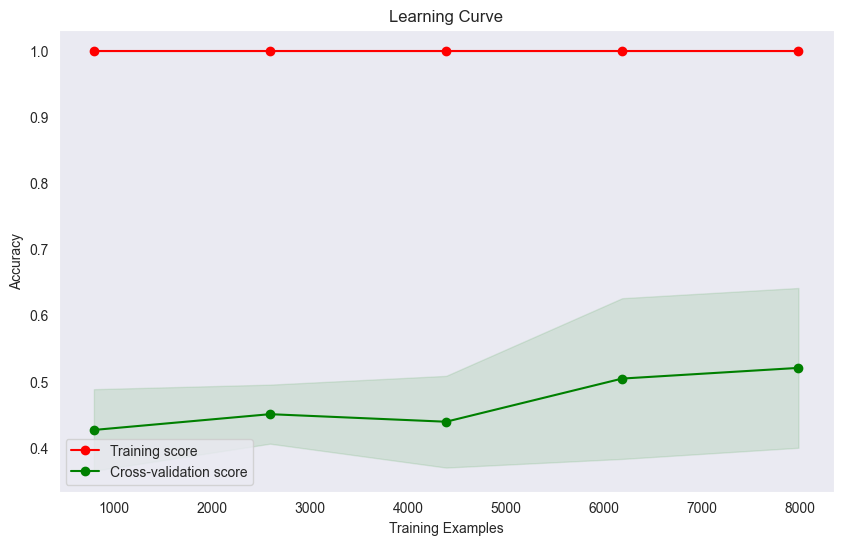

In [275]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Plot the learning curve of an estimator.

    Parameters:
    - estimator: The machine learning model (classifier/regressor) to evaluate.
    - X: The input features.
    - y: The target variable.
    - cv: Cross-validation splitting strategy.
    - train_sizes: Relative or absolute numbers of training examples used for plotting the learning curve.
    - scoring: The scoring metric to use.

    Returns:
    - Plots the learning curve.
    """

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Assuming X contains your features and y contains your labels
# Assuming rf_classifier is your Random Forest classifier
plot_learning_curve(rf_classifier, X, y, cv=5)


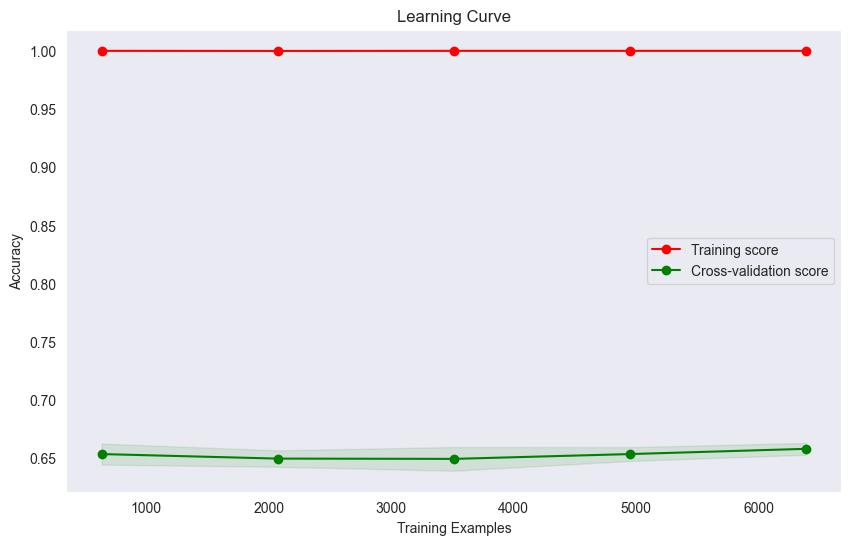

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    """
    Plot the learning curve of an estimator.

    Parameters:
    - estimator: The machine learning model (classifier/regressor) to evaluate.
    - X: The input features.
    - y: The target variable.
    - cv: Cross-validation splitting strategy.
    - train_sizes: Relative or absolute numbers of training examples used for plotting the learning curve.
    - scoring: The scoring metric to use.

    Returns:
    - Plots the learning curve.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel(scoring.capitalize())
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Assuming X contains your features and y contains your labels
# Assuming rf_classifier is your Random Forest classifier
plot_learning_curve(rf_classifier, X_train, y_train, cv=5)


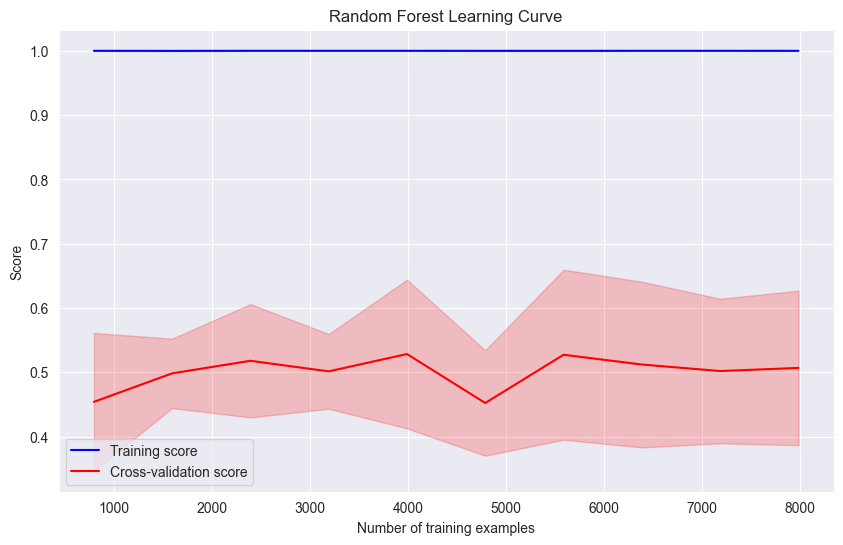

In [277]:
# Plot learning curve
train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color='blue'
)
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='red')
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color='red'
)

plt.title('Random Forest Learning Curve')
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

In [216]:
X_train.shape

(7983, 161)

In [221]:
feature_importances = rf_classifier.feature_importances_
print(feature_importances)
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Number of Features you Want to Select
top_n = 50

# Top 50 important features
top_feature_importances = feature_importances[indices][:top_n]
top_features = X.columns[indices][:top_n]

print(f'Top {top_n} features: \n {top_features}')

[0.00102746 0.00622849 0.0052591  0.00787981 0.00982981 0.00897418
 0.00838208 0.00738451 0.00762739 0.00772117 0.00780896 0.00227134
 0.00322231 0.00339625 0.00474432 0.00406197 0.00453987 0.00171898
 0.00285169 0.00350855 0.00588584 0.00735232 0.00745829 0.
 0.00851856 0.00749394 0.00751866 0.00695873 0.00802866 0.00719717
 0.007099   0.00670874 0.00693808 0.00674737 0.00901814 0.00844983
 0.00742712 0.00783875 0.00732235 0.0072791  0.00898584 0.00703305
 0.0072414  0.00722334 0.00775997 0.00735223 0.         0.00945356
 0.00028121 0.         0.00952207 0.00824843 0.00679624 0.00028075
 0.00025712 0.00039341 0.00851957 0.00727163 0.00722066 0.00711075
 0.         0.00485692 0.         0.0063268  0.         0.00540755
 0.         0.00762366 0.         0.00914855 0.         0.00756041
 0.         0.00766657 0.         0.00809679 0.00492999 0.00458245
 0.00347459 0.0049376  0.00470137 0.00324854 0.00533056 0.00405111
 0.00356057 0.00786826 0.00757583 0.00771629 0.00787922 0.00758443
 0.

In [222]:
for__f

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f153,f154,f155,f156,f157,f158,f159,f160,f161,label
0,0.000463,15139,-43.1,43.0,-0.1,-4.8,-5.1,-4.3,-15.2,4.8,...,-123.8,695.2,-123.8,-123.8,695.2,695.2,-123.8,-123.8,695.2,0
1,0.000463,15140,-43.1,43.0,-0.1,-4.7,-5.1,-2.4,-15.2,4.7,...,-123.8,695.2,-123.8,-123.8,695.2,695.2,-123.8,-123.8,695.2,0
2,0.000463,15141,-37.4,43.0,5.6,-1.9,-0.6,-2.4,-6.7,4.7,...,-123.8,695.2,-123.8,-123.8,695.2,695.2,-123.8,-123.8,695.2,0
3,0.000463,15142,-37.4,37.4,0.0,-3.7,-6.2,-10.2,-12.3,-0.8,...,-123.8,695.2,-123.8,-123.8,695.2,695.2,-123.8,-123.8,695.2,1
4,0.000463,15143,-39.6,36.5,-3.1,-3.7,-9.4,-10.2,-12.4,-0.9,...,-129.4,689.6,-129.4,-129.4,689.6,689.6,-129.4,-129.4,689.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000414,25191,-29.5,29.4,-0.1,3.5,9.6,9.7,-23.7,-5.5,...,-41.3,440.2,-41.3,-41.3,440.2,440.2,-41.3,-41.3,440.2,0
9996,0.000414,25192,-29.5,29.4,-0.1,3.4,9.6,9.7,-21.5,-5.6,...,-41.3,440.2,-41.3,-41.3,440.2,440.2,-41.3,-41.3,440.2,0
9997,0.000414,25193,-36.7,36.6,-0.1,3.7,9.7,12.6,-21.4,-5.5,...,-41.3,440.2,-41.3,-41.3,440.2,440.2,-41.3,-41.3,440.2,0
9998,0.000414,25194,-36.7,48.5,11.8,22.6,21.6,23.7,-9.6,3.0,...,-41.2,440.3,-41.2,-41.2,440.3,440.3,-41.2,-41.2,440.3,0


C:\Users\Muhammad Hamza\AppData\Local\Temp\ipykernel_8488\2119885082.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x= data_without_last_price.columns, y= feature_importances, palette='magma')


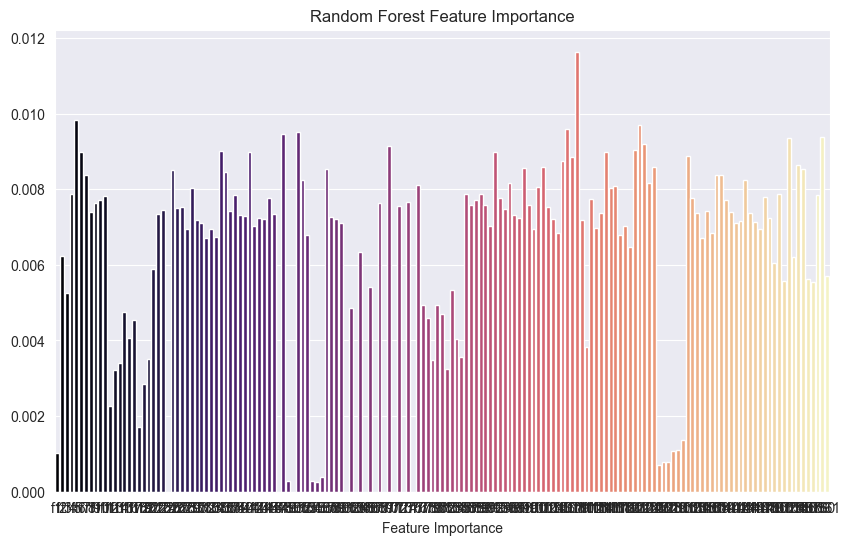

In [223]:
# visualizing feature importances

data_without_last_price = for__f.drop('label', axis=1)

plt.figure(figsize=(10, 6))
sns.barplot(x= data_without_last_price.columns, y= feature_importances, palette='magma')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()


In [224]:
# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance}")

f1: 0.0010274647270343072
f2: 0.006228489686038142
f3: 0.005259099542798037
f4: 0.007879812562623812
f5: 0.009829811473833971
f6: 0.008974180407991233
f7: 0.008382081998638853
f8: 0.00738450845109591
f9: 0.00762739141806252
f10: 0.007721165683531285
f11: 0.007808962797433819
f12: 0.0022713374330375798
f13: 0.0032223096765445196
f14: 0.003396248985631393
f15: 0.004744315396666118
f16: 0.004061974818971767
f17: 0.0045398707342911935
f18: 0.0017189819516859725
f19: 0.0028516904987781716
f20: 0.003508549441790199
f21: 0.005885836707939205
f22: 0.00735232087066797
f23: 0.007458288237880742
f24: 0.0
f25: 0.008518556277432312
f26: 0.007493944468750665
f27: 0.007518662054608766
f28: 0.006958728368156011
f29: 0.008028655715586027
f30: 0.007197165319427695
f31: 0.007099004677133499
f32: 0.006708743767523985
f33: 0.006938078988695248
f34: 0.006747370217255134
f35: 0.009018136455479268
f36: 0.008449827743251603
f37: 0.007427119529084335
f38: 0.007838750224346703
f39: 0.007322350909015072
f40: 0.00

In [225]:
final_colmns = ['label'] + list(top_features)
data2 = for__f[final_colmns]
print("Data Shape Selecting the Features: ",data2.shape)
data2

Data Shape Selecting the Features:  (9979, 51)


,label,f109,f5,f122,f107,f51,f48,f160,f153,f123,...,f89,f151,f86,f159,f38,f11,f148,f133,f93,f45
0,0,-7.72,-0.1,-0.54,-530.46,5.93,2.24,-123.8,-123.8,-1.60,...,-4.57,-123.8,-1.47,-123.8,195.309,35.0,7973000.0,1644000.0,-7.18,184.885
1,0,-7.72,-0.1,-0.54,-532.99,5.62,3.38,-123.8,-123.8,-1.22,...,-4.88,-123.8,-1.61,-123.8,145.014,40.0,7792000.0,1671000.0,-7.19,180.699
2,0,-7.57,5.6,-0.67,-386.08,5.49,3.88,-123.8,-123.8,0.44,...,-5.01,-123.8,-1.75,-123.8,145.557,39.9,6117218.0,1588000.0,-7.32,141.867
3,1,-5.73,0.0,0.49,-5.30,5.62,1.88,-123.8,-123.8,0.31,...,-4.88,-123.8,-1.89,-123.8,145.648,32.3,6109443.0,1650497.0,-7.63,141.690
4,0,-9.41,-3.1,0.72,253.46,5.37,1.26,-129.4,-129.4,-0.98,...,-5.13,-129.4,-1.13,-129.4,145.627,22.5,6061858.0,1129311.0,-4.84,140.583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,-1.97,-0.1,0.19,859.58,10.27,7.18,-41.3,-41.3,20.97,...,-5.23,-41.3,-2.61,-41.3,254.893,48.3,7759000.0,1054000.0,-4.66,181.507
9996,0,-1.68,-0.1,1.91,978.63,10.50,4.78,-41.3,-41.3,21.96,...,-5.00,-41.3,-6.09,-41.3,254.753,48.4,8033000.0,1117000.0,-4.33,187.905
9997,0,19.19,-0.1,3.25,1393.41,10.74,4.80,-41.3,-41.3,20.49,...,-4.86,-41.3,-5.08,-41.3,256.137,42.3,8032811.0,1058769.0,-4.01,187.900
9998,0,19.24,11.8,3.25,1878.83,11.45,4.84,-41.2,-41.2,17.36,...,-11.15,-41.2,-4.54,-41.2,232.443,50.4,8038041.0,1116472.0,-3.68,188.026


In [226]:
# Our data set  <<Features>> <<Labels>>
X = data2.iloc[:, 1:]
y = data2.iloc[:, 0]
# X = scaler.fit_transform(X)
X.shape , y.shape

((9979, 50), (9979,))

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, )

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_train)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))



# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 100.00%
Accuracy: 68.24%


In [231]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Perform 5-fold cross-validation (you can adjust the number of folds with the cv parameter)
cv_scores = cross_val_score(rf_classifier, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.67438948 0.66624922 0.65497808 0.67669173 0.660401  ]


### Correlation Heatmap of the New Dataset

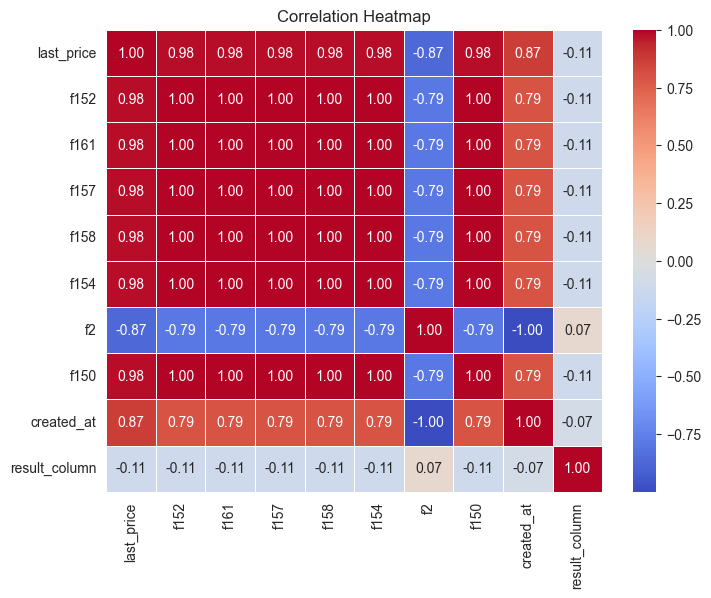

In [154]:
correlation_matrix = data.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Plot tha Box_Plot for Checking the Outliers

IndexError: index 8 is out of bounds for axis 0 with size 8

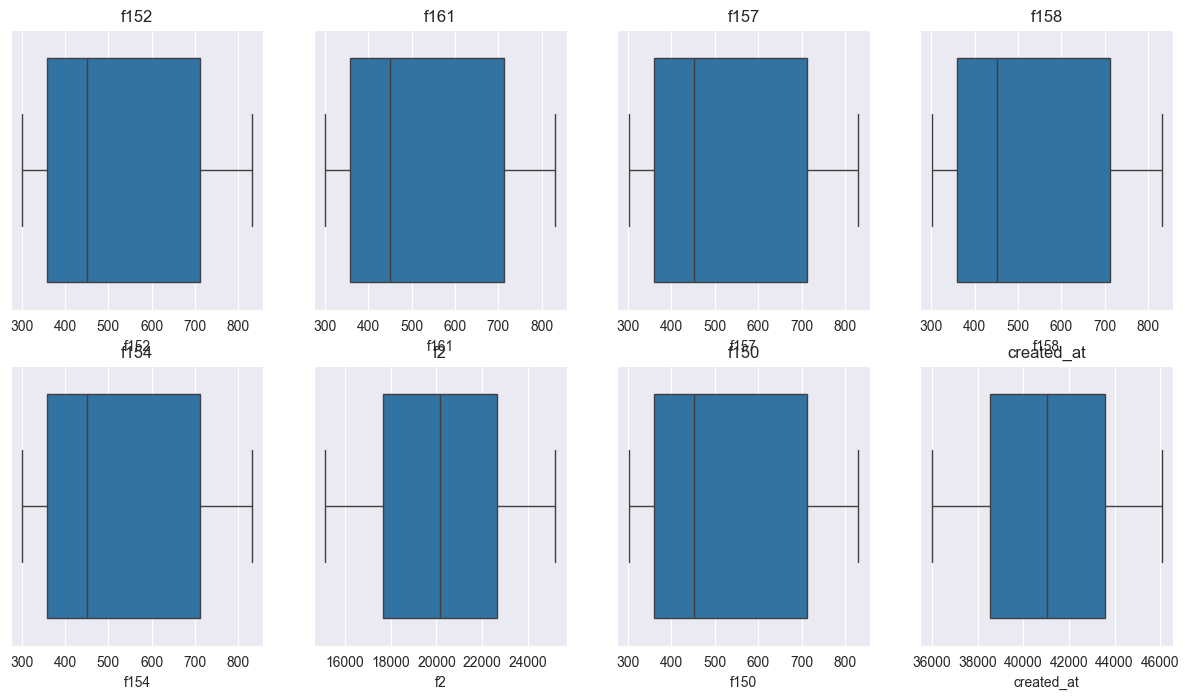

In [155]:
# Number of rows and columns
nrows = 2
ncols = len(X.columns) // nrows

# Create subplots for each column
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
axes = axes.flatten()

# Plot box plots for each column
for i, column in enumerate(X.columns):
    sns.boxplot(x=X[column], ax=axes[i])
    axes[i].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()

### Distribution of each Data Column

In [ ]:
# Identify the target variable column name
target_variable = 'last_price'
columns_to_plot = [col for col in data.columns if col != target_variable]

# Create subplots in a single figure
num_plots = len(columns_to_plot)
num_rows = num_plots // 2
if num_plots % 2 != 0:
    num_rows += 1

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))
fig.suptitle('Histograms of Columns (Excluding Target Variable)', y=1.02)

# Create histograms and print skewness for each selected column
for i, column in enumerate(columns_to_plot):
    row_index = i // 2
    col_index = i % 2

    # Calculate skewness
    skew_value = data[column].skew()

    # Determine skewness type
    skew_type = "Approx. Symmetric" if -0.5 <= skew_value <= 0.5 else "Right-skewed" if skew_value > 0.5 else "Left-skewed"

    # Plot histogram
    axes[row_index, col_index].hist(data[column], bins=30, color='lightblue', edgecolor='black')
    axes[row_index, col_index].set_title(f'{column}\nSkewness: {skew_value:.2f} ({skew_type})')
    axes[row_index, col_index].set_xlabel('Values')
    axes[row_index, col_index].set_ylabel('Frequency')


    # Calculate statistics
    mean_value = data[column].mean()
    median_value = data[column].median()
    mode_value = data[column].mode()[0]

     # Add lines for mean, median, and mode
    axes[row_index, col_index].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
    axes[row_index, col_index].axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
    axes[row_index, col_index].axvline(mode_value, color='orange', linestyle='dashed', linewidth=2, label=f'Mode: {mode_value:.2f}')


plt.tight_layout()
plt.show()

## Pair Plot Of the Data

In [ ]:
# Draw the Pair Plot
sns.pairplot(data)
plt.show()

### Pair Plot with the kernel density plots

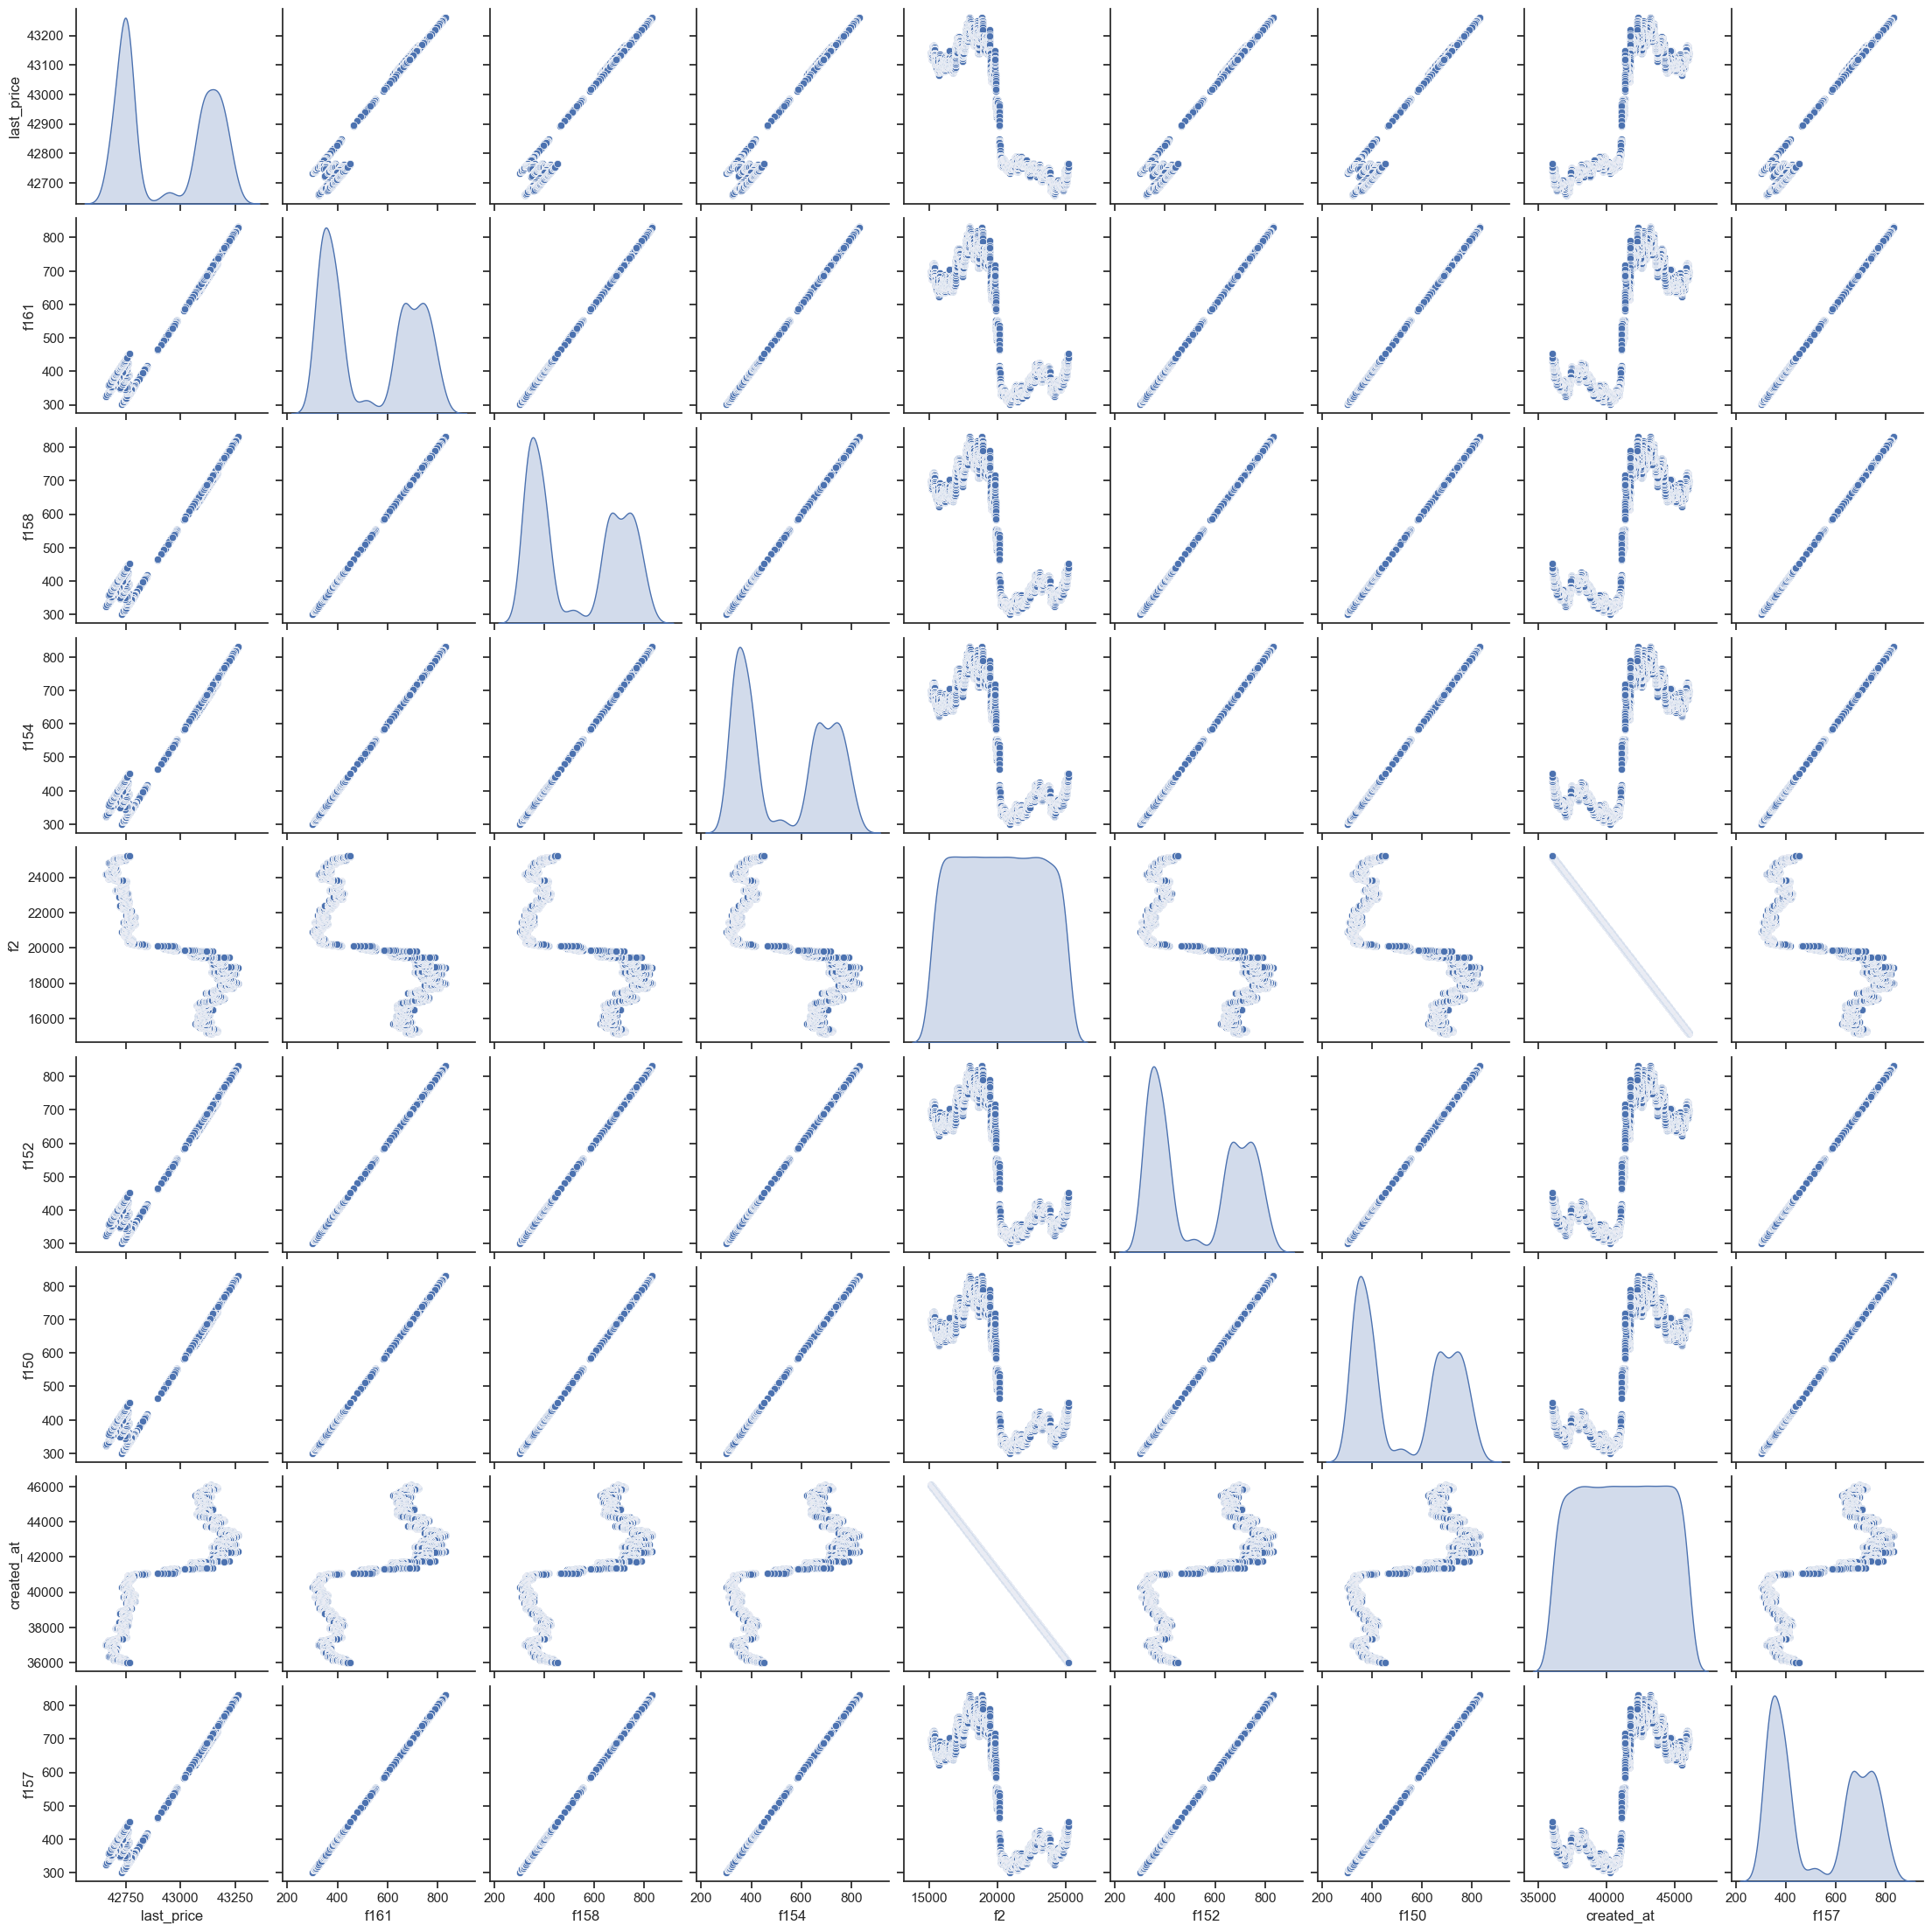

In [132]:
# Pair Plot with the kernel density plots
sns.set(style="ticks")
sns.pairplot(data, diag_kind="kde")

plt.show()


## Scatter Plot of Final Features

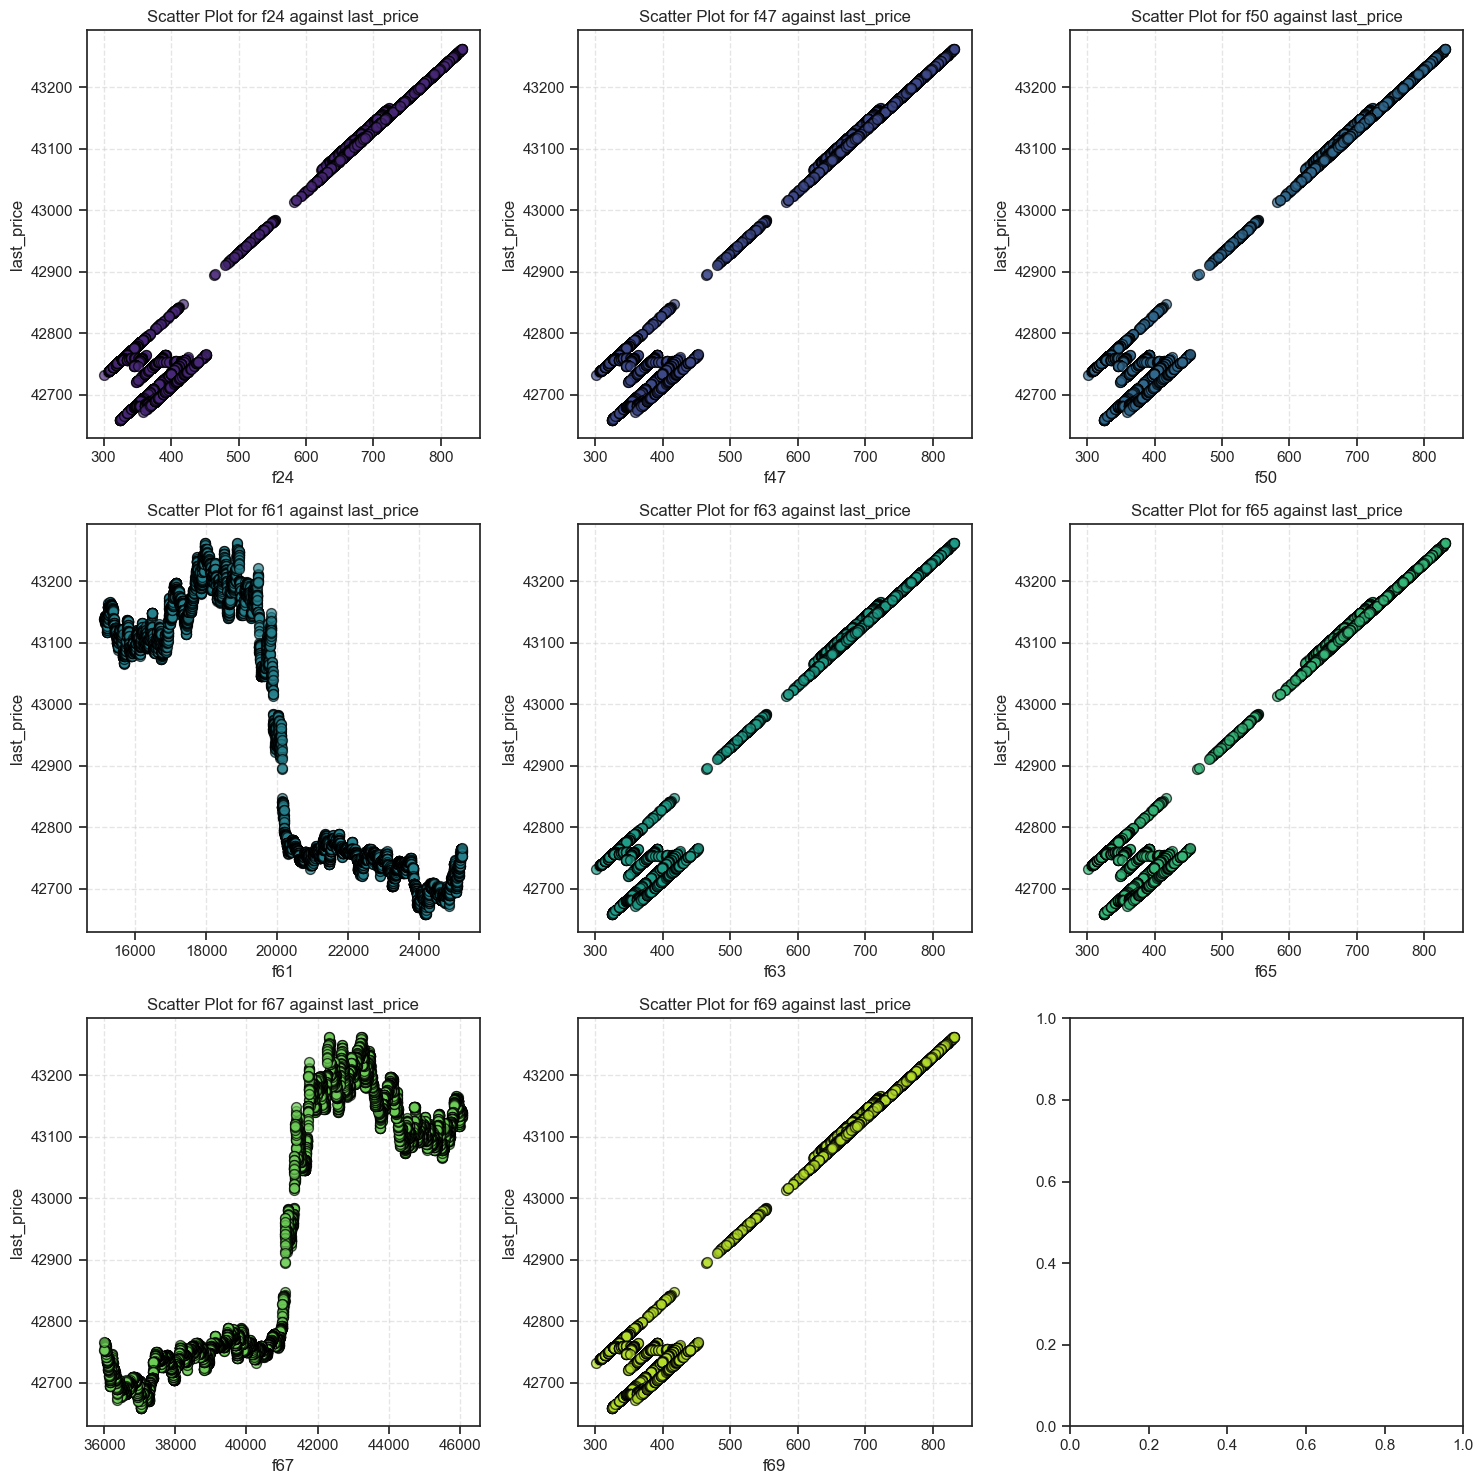

In [133]:
# # Plot all the data
# sns.pairplot(data, hue="target_names", markers=["o", "s", "D"])
# plt.show()# Assuming x and y are your dataframes or arrays
num_features = X.shape[1]
num_rows = int(np.ceil(num_features / 3))
num_cols = min(num_features, 3)

# Use a seaborn color palette for a more appealing look
colors = sns.color_palette("viridis", num_features)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
axes = axes.flatten()

# Loop through each column and plot the scatter plot in the corresponding subplot
for feature_index, ax in enumerate(axes):
    if feature_index < num_features:
        chosen_feature = X.iloc[:, feature_index]

        # Customize scatter plot
        ax.scatter(chosen_feature, y, color=colors[feature_index], edgecolors='black', alpha=0.7, s=50)

        # Add grid lines
        ax.grid(True, linestyle='--', alpha=0.5)

        # Set labels and title
        ax.set_xlabel(f'{zero_columns[feature_index]}')
        ax.set_ylabel('last_price')
        ax.set_title(f'Scatter Plot for {zero_columns[feature_index]} against last_price')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## Train Test Split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Model on New Data Set

In [135]:
# Create a RandomForestRegressor instance
rf_model = RandomForestRegressor()

# Fit the model to your training data
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [136]:
# Get feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(data.columns, feature_importances):
    print(f"{feature}: {importance}")

last_price: 0.18642350676856545
f161: 0.12132842077322378
f158: 0.1659758210483096
f154: 0.00887701348663425
f2: 0.19505592080522188
f152: 0.17553540090153402
f150: 0.00967137027569786
created_at: 0.13713254594081317


In [137]:
predictions  = rf_model.predict(X_train)

In [138]:
mae = mean_absolute_error(y_train, predictions)
print(f"Mean Absolute Error for Training Data: {mae:.2f}")

Mean Absolute Error for Training Data: 0.03


In [139]:
predictions  = rf_model.predict(X_test)

In [140]:
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error for Test Data: {mae:.2f}")

Mean Absolute Error for Test Data: 0.07


## Train the Linear Regression Model

https://chat.openai.com/share/8292b71c-7db0-4f8b-82a1-aead6d9aebb4

Linear Regression is effected , as we have selected the more correlated features ,Linear Regression is more sensitive to it
when I use the Polynomial Features (Feature Engineering) , it is performing well.

### Train the Linear Regression Model On the Final Data Set

In [141]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
# Create a linear regression model
model = LinearRegression()
# Train the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [143]:
# Get feature importances
feature_importances = loaded_rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(data.columns, feature_importances):
    print(f"{feature}: {importance}")

last_price: 0.0010076541559621165
f161: 0.0026472019138840653
f158: 2.9133601816003924e-06
f154: 0.003366068691640335
f2: 1.1558337404673593e-06
f152: 6.861990150044223e-08
f150: 4.873839809123762e-08
created_at: 3.278982565375229e-08
f157: 9.91359972654213e-08


In [144]:
# Make predictions on the test data
y_pred = model.predict(X_train_scaled)
# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print(f'Mean Squared Error for the Train Data: {mse}')


# Make predictions on the test data
y_pred = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for the Test Data: {mse}')

Mean Squared Error for the Train Data: 496.3039998101583
Mean Squared Error for the Test Data: 503.1356411137432


### Train the Linear Regression Model on the Polynomial features

In [145]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=5)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

model.fit(X_train_poly, y_train)

LinearRegression()

In [146]:
# Make predictions on the test data
y_pred = model.predict(X_train_poly)
# Evaluate the model
mse = mean_squared_error(y_train, y_pred)
print(f'Mean Squared Error for the Train Data: {mse}')


# Make predictions on the test data
y_pred = model.predict(X_test_poly)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for the Test Data: {mse}')

Mean Squared Error for the Train Data: 29.288516609258973
Mean Squared Error for the Test Data: 30.34179626092863


### Train the Linear Regression on the Original Dataset(All Column/Features)

In [147]:
# Our data set <<Features>> <<Labels>>

X_custom = same_data.iloc[:, 1:same_data.shape[1]]
y_custom = same_data.iloc[:, 0]
X_custom.shape, y_custom.shape

X_custom = scaler.fit_transform(X_custom)

X_train_custom, X_test_custom, y_train_custom, y_test_custom = train_test_split(X_custom, y_custom, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler_custom = StandardScaler()
X_train_scaled_custom = scaler_custom.fit_transform(X_train_custom)
X_test_scaled_custom = scaler_custom.transform(X_test_custom)

# Create a linear regression model
model_custom = LinearRegression()
# Train the model on the training data
model_custom.fit(X_train_scaled_custom, y_train_custom)

# Make predictions on the train data
y_pred_train_custom = model_custom.predict(X_train_scaled_custom)
# Evaluate the model for train data
mse_train_custom = mean_squared_error(y_train_custom, y_pred_train_custom)
r2_train_custom = r2_score(y_train_custom, y_pred_train_custom)
print(f'Mean Squared Error for the Train Data: {mse_train_custom}')

# Make predictions on the test data
y_pred_test_custom = model_custom.predict(X_test_scaled_custom)
# Evaluate the model for test data
mse_test_custom = mean_squared_error(y_test_custom, y_pred_test_custom)
print(f'Mean Squared Error for the Test Data: {mse_test_custom}')


Mean Squared Error for the Train Data: 17.042679975037228
Mean Squared Error for the Test Data: 17.555054145477822


In [148]:
# Get the coefficients (weights) of the features
coefficients = model_custom.coef_

# Print feature importances
for feature, coefficient in zip(same_data.columns, coefficients):
    print(f"{feature}: {coefficient}")


last_price: -1591.5880102368899
id: 2159.416873309603
created_at: -9.199126372425326
f1: 519.1338785446494
f2: 792288764354.8544
f3: 1032975315535.8185
f4: -592178736786.6328
f5: 0.17937417223964758
f6: 0.12917681949767257
f7: 0.9198862755280857
f8: 0.0644940530417557
f9: 3.5597737108176375
f10: 2.226566465826835
f11: -0.23873761259253
f12: -1.693309521799506
f13: -2.655168175473193
f14: 36.27761375687459
f15: 238621285100.22958
f16: -238621285128.36945
f17: -1.2660463938596251
f18: 0.2522944351867551
f19: -11.065580315841316
f20: 30.858588564236356
f21: -392972212813.63745
f22: 394086518085.08954
f23: -205878852240.93875
f24: 32.66788105262691
f25: -121.2882181656457
f26: -11197573589.198494
f27: 13832149426.144041
f28: 81.30057107065963
f29: -8004695681.762661
f30: -463.53753028672986
f31: -311.7140197753906
f32: -83.39370727539062
f33: -309.7622375488281
f34: 5185170136.592407
f35: 339.908203125
f36: -102.60662841796875
f37: 81.6800765991211
f38: -201.51776123046875
f39: -568.283569

In [ ]:
from sklearn.svm import SVR



svm_model = SVR(kernel='linear')


svm_model.fit(X_train, y_train)


y_pred = svm_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")